In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 21 13:44:53 2024

@author: morit
"""

import json
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import numpy as np
import pandas as pd

## The following cells just load the data, please replace with your own files and paths, you should read .geojson data, with the same content that the google drive folder provides

In [2]:
with open("C:/Users/morit/Documents/__AI_hackaton/data_subset/Tree Crown vector datasets-20240520T095639Z-001/Tree Crown vector datasets/manaus_800.geojson", 'r') as file:
    data_800 = json.load(file)

In [3]:
with open("C:/Users/morit/Documents/__AI_hackaton/data_subset/Tree Crown vector datasets-20240520T095639Z-001/Tree Crown vector datasets/manaus_1600.geojson", 'r') as file:
    data_1600 = json.load(file)

In [4]:
with open("C:/Users/morit/Documents/__AI_hackaton/data_subset/Tree Crown vector datasets-20240520T095639Z-001/Tree Crown vector datasets/manaus_2400.geojson", 'r') as file:
    data_2400 = json.load(file)

In [5]:
with open("C:/Users/morit/Documents/__AI_hackaton/data_subset/Tree Crown vector datasets-20240520T095639Z-001/Tree Crown vector datasets/manaus_3200.geojson", 'r') as file:
    data_3200 = json.load(file)

In [6]:
with open("C:/Users/morit/Documents/__AI_hackaton/data_subset/Tree Crown vector datasets-20240520T095639Z-001/Tree Crown vector datasets/manaus_4000.geojson", 'r') as file:
    data_4000 = json.load(file)

## This provides utilities to convert the data to dataframes for easier handling

In [11]:
def add_extreme_coordinates(polygon_data):
    polygon_coords = np.array(polygon_data['geometry']['coordinates'][0])
    
    polygon_data['geometry']['max_lat'] = max(polygon_coords[:,1])
    polygon_data['geometry']['min_lat'] = min(polygon_coords[:,1])
    polygon_data['geometry']['max_lon'] = max(polygon_coords[:,0])
    polygon_data['geometry']['min_lon'] = min(polygon_coords[:,0])


def turn_into_dataframe(data):
    data_list = data['features']
    
    for i in range(len(data_list)):    
        add_extreme_coordinates(data_list[i])
    
    df = pd.DataFrame(data_list).drop(columns='type')

    dict_cols = ['properties', 'geometry']
    for dict_col in dict_cols:
        dict_df = pd.json_normalize(df[dict_col])
        # Merge the new columns back into the original DataFrame
        df = df.drop(columns=[dict_col]).join(dict_df)
    df['coordinates'] = df['coordinates'].apply(lambda x : x[0])
    df['polygon'] = df['coordinates'].apply(lambda x : Polygon(x))

    df = df.drop(columns = ['type']) 
    return df

## Some functions for plotting

In [12]:
# Function to plot a polygon
def plot_polygon(ax, polygon, color, label = "label"):
    if not polygon.is_empty:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5, label=label)

def plot_polygons(list_polygons, first_one_different = False, dpi=150):        
    # Plot the polygons and their intersection
    plt.figure(dpi = dpi)
    fig, ax = plt.subplots()
    
    if first_one_different:
        plot_polygon(ax, list_polygons[0], 'red', f"polygon {0}")
        for i,polygon in enumerate(list_polygons[1:]):
            plot_polygon(ax, polygon, 'blue', f"polygon {i}")
    else:
        for i,polygon in enumerate(list_polygons):
            plot_polygon(ax, polygon, 'blue', f"polygon {i}")


    # Plot the intersection
    #plot_polygon(ax, intersection, 'red', 'Intersection')

    # Add legend
    #ax.legend()

    # Set axis limits
    ax.set_aspect('equal')

    # Set title
    ax.set_title('Polygons and their Intersection')
    plt.ylabel('lat')
    plt.xlabel('lon')

    plt.show()

def plot_polygons_with_colors(list_polygons, list_colors , dpi=150):        
    # Plot the polygons and their intersection
    plt.figure(dpi = dpi)
    fig, ax = plt.subplots()
    
    
        
    for polygon, color in zip(list_polygons, list_colors):
        plot_polygon(ax, polygon, color)

    # Set axis limits
    ax.set_aspect('equal')

    # Set title
    ax.set_title('Polygons and their Intersection')
    plt.ylabel('lat')
    plt.xlabel('lon')

    plt.show()

def plot_polygons_from_df(df, dpi = 150):
    list_polygons = []
    for index, row in df.iterrows():
        list_polygons.append(row['polygon'])
    plot_polygons(list_polygons=list_polygons, dpi = dpi)

def map_color(id):
    if id[:5] == "df_40":
        return 'blue'
    elif id[:5] == "df_32":
        return 'green'
    elif id[:5] == "df_24":
        return 'yellow'
    elif id[:5] == "df_16":
        return 'orange'
    elif id[:5] == "df_80":
        return 'red'
    else:
        return 'black'

def plot_polygons_from_df_with_color(df, dpi = 150):

    df['plot_colors'] = df['id'].apply(map_color)
    list_polygons = []
    list_colors = []
    for index, row in df.iterrows():
        list_polygons.append(row['polygon'])
        list_colors.append(row['plot_colors'])
    plot_polygons_with_colors(list_polygons=list_polygons, list_colors = list_colors, dpi = dpi)


## Functions for the combination of the layers

#### helper functions

In [13]:
def intersection(polygon, polygon_comparison):
    return polygon.intersection(polygon_comparison)

def intersection_area(polygon, polygon_comparison):
    return intersection(polygon, polygon_comparison).area

def intersection_area_ratio(polygon, polygon_comparison):
    return intersection_area(polygon, polygon_comparison) / polygon.area

### the actual combination of layers and doublet reduction

In [55]:
def mark_id_to_be_dropped(df, id):
    df.loc[df['id']== id, 'roundness'] = None

def combine_different_tile_size(df_smaller, df_bigger):

    df_result = df_bigger.copy()

    for i in range (len(df_smaller)):
        max_lat = df_smaller.iloc[i]['max_lat']
        min_lat = df_smaller.iloc[i]['min_lat']
        max_lon = df_smaller.iloc[i]['max_lon']
        min_lon = df_smaller.iloc[i]['min_lon']
        
        polygon = df_smaller.iloc[i]['polygon']
        
        relevant_subset = df_bigger.loc[( ((max_lat < df_bigger['max_lat']) & (max_lat > df_bigger['min_lat'])) | \
                                    ((min_lat < df_bigger['max_lat']) & (min_lat > df_bigger['min_lat'])) ) & \
                                    ( ((max_lon < df_bigger['max_lon']) & (max_lon > df_bigger['min_lon'])) | \
                                    ((min_lon < df_bigger['max_lon']) & (min_lon > df_bigger['min_lon'])) ) ]
        
        list_polygons = [polygon]
        
        for index, row in relevant_subset.iterrows():
            list_polygons.append(row['polygon'])
                
        add_polygon = True
        threashold = 0.15
        for comparison_polygon in list_polygons[1:]:
            ratio = intersection_area_ratio(polygon, comparison_polygon)
            if ratio > threashold:
                add_polygon = False
        
        if add_polygon:
            # df_result = pd.concat([df_result, df_result.iloc[[i]]], axis= 1, ignore_index=True)#df_result.append(df_result.iloc[i], ignore_index=True)
            df_result = pd.concat([df_result, df_smaller.iloc[[i]]], axis=0, join='outer') # 

    return df_result


def remove_doublicates_area(df_input):
    df_result = df_input.copy()

    for i in range (len(df_result)):
        max_lat = df_input.iloc[i]['max_lat']
        min_lat = df_input.iloc[i]['min_lat']
        max_lon = df_input.iloc[i]['max_lon']
        min_lon = df_input.iloc[i]['min_lon']
        
        polygon = df_input.iloc[i]['polygon']
        
        relevant_subset = df_input.loc[( ((max_lat < df_result['max_lat']) & (max_lat > df_result['min_lat'])) | \
                                    ((min_lat < df_result['max_lat']) & (min_lat > df_result['min_lat'])) ) & \
                                    ( ((max_lon < df_result['max_lon']) & (max_lon > df_result['min_lon'])) | \
                                    ((min_lon < df_result['max_lon']) & (min_lon > df_result['min_lon'])) ) ]

        threashold = 0.15
        for j in range(len(relevant_subset)):
            ratio_current_choice = intersection_area_ratio(polygon = polygon, polygon_comparison= relevant_subset.iloc[j]['polygon'])
            ratio_alternative_choice = intersection_area_ratio(polygon = relevant_subset.iloc[j]['polygon'], polygon_comparison= polygon)
            if  ratio_current_choice > threashold or ratio_alternative_choice > threashold: # or ratio_alternative_choice > threashold:

                if polygon.area >  relevant_subset.iloc[j]['polygon'].area:
                    mark_id_to_be_dropped(df=df_result, id = relevant_subset.iloc[j]['id'])               
                else:
                    mark_id_to_be_dropped(df=df_result, id = df_input.iloc[i]['id'])  
                    break  


    df_result = df_result.dropna()
    return df_result

    

    
def clean(df, score_threashold = 0.5):
    df = df.loc[df['score']> score_threashold ]
    return df

def process(list_df, score_threashold = 0.2):
    for i in range(len(list_df)):
        list_df[i] = clean(list_df[i], score_threashold=score_threashold)
    print('data cleaned')
    df_res = remove_doublicates_area(df_input= list_df[0])
    print('first data prepared')
    for i, df in enumerate( list_df[1:] ):
        df_res = combine_different_tile_size(df_smaller=df, df_bigger=df_res)
        print(i)
    
    df_res = remove_doublicates_area(df_input= df_res) # because somehow there are still doublicates before

    return df_res
            
        

## Functions needed to export the data as .geojson again

In [56]:
def row_to_feature(row):
    feature = {
        "id": row['id'],
        "type": "Feature",
        "properties": {
            "area": row['area'],
            "score": row['score'],
            "class": row['class'],
            "color": row['color'],
            "image_id": row['image_id'],
            "perimeter": row['perimeter'],
            "roundness": row['roundness']
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [row['coordinates']]
        }
    }
    return feature


def export_df_as_geojson(df, filename = 'output'):
    features = [row_to_feature(row) for idx, row in df.iterrows()]

    feature_collection = {
        "type": "FeatureCollection",
        "features": features
    }

    output_geojson = json.dumps(feature_collection)

    with open(f'{filename}.geojson', 'w') as f:
        f.write(output_geojson)

    print(f"GeoJSON data exported to '{filename}.geojson' file.")

# EXAMPLE: actual treatment of the data

In [57]:
df_800 = turn_into_dataframe(data_800)
df_1600 = turn_into_dataframe(data_1600)
df_2400 = turn_into_dataframe(data_2400)
df_3200 = turn_into_dataframe(data_3200)
df_4000 = turn_into_dataframe(data_4000)

# making sure ids stay unique even for combinations of doublets
df_800['id'] = "df_800_"+df_800['id']
df_1600['id'] = "df_1600_"+df_1600['id']
df_2400['id'] = "df_2400_"+df_2400['id']
df_3200['id'] = "df_3200_"+df_3200['id']
df_4000['id'] = "df_4000_"+df_4000['id']

In [58]:
df_4000

id        area     score  class        color image_id  \
0        df_4000_0   60.798305  0.873439      0      255,0,0        0   
1        df_4000_1   42.678805  0.821304      0      0,255,0        0   
2        df_4000_2  296.110790  0.765647      0     84,0,127        0   
3        df_4000_3   55.954144  0.611097      0    0,255,255        0   
4        df_4000_4   18.991014  0.609288      0        0,0,0        0   
...            ...         ...       ...    ...          ...      ...   
1083  df_4000_1080  290.119304  0.686680      0    0,113,188      112   
1084  df_4000_1081   49.200372  0.667695      0      0,127,0      114   
1085  df_4000_1082  162.992910  0.718769      0    255,170,0      116   
1086  df_4000_1086   26.234187  0.372974      0   84,255,127      116   
1087  df_4000_1087   31.449125  0.361396      0  218,218,218      116   

      perimeter  roundness                                        coordinates  \
0     38.757353   0.508620  [[-60.64681673678601, -2.9486674574996883], [-...   
1     31.302368   0.547353  [[-60.64655854311238, -2.9487283874714936], [-...   
2     81.760379   0.556645  [[-60.64677751749381, -2.948839275351216], [-6...   
3     35.716946   0.551180  [[-60.64669044132721, -2.948696638520668], [-6...   
4     20.307625   0.578682  [[-60.64677331542679, -2.948771108486208], [-6...   
...         ...        ...                                                ...   
1083  75.783830   0.634795  [[-60.64255547202828, -2.9560820982889484], [-...   
1084  35.339801   0.495051  [[-60.642118679398465, -2.9546998475188695], [...   
1085  60.923116   0.551842  [[-60.64205950811492, -2.9554428611586023], [-...   
1086  23.407811   0.601667  [[-60.64200791609234, -2.9556062748047975], [-...   
1087  24.916129   0.636586  [[-60.641900996878114, -2.9556055744605993], [...   

       max_lat   min_lat    max_lon    min_lon  \
0    -2.948667 -2.948757 -60.646767 -60.646850   
1    -2.948728 -2.948792 -60.646510 -60.646587   
2    -2.948839 -2.949004 -60.646692 -60.646885   
3    -2.948697 -2.948780 -60.646649 -60.646722   
4    -2.948771 -2.948817 -60.646744 -60.646789   
...        ...       ...        ...        ...   
1083 -2.956082 -2.956193 -60.642365 -60.642608   
1084 -2.954700 -2.954790 -60.642084 -60.642148   
1085 -2.955443 -2.955577 -60.641994 -60.642130   
1086 -2.955606 -2.955658 -60.641972 -60.642025   
1087 -2.955606 -2.955673 -60.641877 -60.641916   

                                                polygon  
0     POLYGON ((-60.64681673678601 -2.94866745749968...  
1     POLYGON ((-60.64655854311238 -2.94872838747149...  
2     POLYGON ((-60.64677751749381 -2.94883927535121...  
3     POLYGON ((-60.64669044132721 -2.94869663852066...  
4     POLYGON ((-60.64677331542679 -2.94877110848620...  
...                                                 ...  
1083  POLYGON ((-60.64255547202828 -2.95608209828894...  
1084  POLYGON ((-60.642118679398465 -2.9546998475188...  
1085  POLYGON ((-60.64205950811492 -2.95544286115860...  
1086  POLYGON ((-60.64200791609234 -2.95560627480479...  
1087  POLYGON ((-60.641900996878114 -2.9556055744605...  

[1088 rows x 14 columns]

In [59]:
list_df = [df_4000, df_3200]#, df_2400, df_1600, df_800]
df_result = process(list_df)

data cleaned
first data prepared
0


In [60]:
display(df_result)

id        area     score  class        color image_id  \
1        df_4000_1   42.678805  0.821304      0      0,255,0        0   
2        df_4000_2  296.110790  0.765647      0     84,0,127        0   
3        df_4000_3   55.954144  0.611097      0    0,255,255        0   
4        df_4000_4   18.991014  0.609288      0        0,0,0        0   
5        df_4000_5   89.022054  0.501927      0  153,153,153        0   
...            ...         ...       ...    ...          ...      ...   
1607  df_3200_1576   36.356531  0.436983      0      0,0,212      151   
1628  df_3200_1619   18.706213  0.504652      0     36,36,36      158   
1629  df_3200_1622   72.175329  0.418842      0   170,84,255      158   
1638  df_3200_1635  492.941216  0.478861      0    255,0,255      163   
1639  df_3200_1636  152.656520  0.449468      0    84,84,127      163   

       perimeter  roundness  \
1      31.302368   0.547353   
2      81.760379   0.556645   
3      35.716946   0.551180   
4      20.307625   0.578682   
5      43.252670   0.597973   
...          ...        ...   
1607   28.575886   0.559491   
1628   20.922594   0.536988   
1629   41.571826   0.524808   
1638  124.449677   0.399961   
1639   57.509775   0.580019   

                                            coordinates   max_lat   min_lat  \
1     [[-60.64655854311238, -2.9487283874714936], [-... -2.948728 -2.948792   
2     [[-60.64677751749381, -2.948839275351216], [-6... -2.948839 -2.949004   
3     [[-60.64669044132721, -2.948696638520668], [-6... -2.948697 -2.948780   
4     [[-60.64677331542679, -2.948771108486208], [-6... -2.948771 -2.948817   
5     [[-60.64660803412396, -2.948323121452129], [-6... -2.948323 -2.948415   
...                                                 ...       ...       ...   
1607  [[-60.64247958670287, -2.955630253925126], [-6... -2.955630 -2.955690   
1628  [[-60.642120348490096, -2.955639472754054], [-... -2.955639 -2.955683   
1629  [[-60.64204797958228, -2.955481194949226], [-6... -2.955481 -2.955578   
1638  [[-60.64199837994623, -2.9549606023223975], [-... -2.954961 -2.955310   
1639  [[-60.641915972795125, -2.9554237631943385], [... -2.955424 -2.955548   

        max_lon    min_lon                                            polygon  
1    -60.646510 -60.646587  POLYGON ((-60.64655854311238 -2.94872838747149...  
2    -60.646692 -60.646885  POLYGON ((-60.64677751749381 -2.94883927535121...  
3    -60.646649 -60.646722  POLYGON ((-60.64669044132721 -2.94869663852066...  
4    -60.646744 -60.646789  POLYGON ((-60.64677331542679 -2.94877110848620...  
5    -60.646533 -60.646634  POLYGON ((-60.64660803412396 -2.94832312145212...  
...         ...        ...                                                ...  
1607 -60.642446 -60.642516  POLYGON ((-60.64247958670287 -2.95563025392512...  
1628 -60.642100 -60.642150  POLYGON ((-60.642120348490096 -2.9556394727540...  
1629 -60.642014 -60.642096  POLYGON ((-60.64204797958228 -2.95548119494922...  
1638 -60.641900 -60.642051  POLYGON ((-60.64199837994623 -2.95496060232239...  
1639 -60.641889 -60.642022  POLYGON ((-60.641915972795125 -2.9554237631943...  

[1267 rows x 14 columns]

In [54]:
export_df_as_geojson(df = df_result, filename = 'result')

GeoJSON data exported to 'result.geojson' file.


<Figure size 1280x960 with 0 Axes>

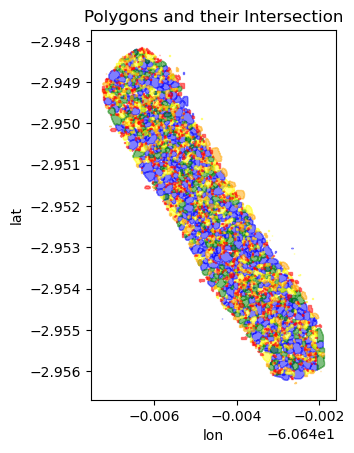

In [19]:
plot_polygons_from_df_with_color(df = df_result, dpi = 200)